In [1]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from tensorflow.keras import layers


2024-12-07 19:22:36.025720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = pd.to_datetime(df['system_time'])
        df_tmp['midpoint'] = df['midpoint']
        
        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]
        
        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]
        
        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]
        
        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

    """
        For a actively traded stock,
        1. If there is an increase in the bid price in future compared to its current or previous value.
            We take the Bid volume.
        2. If the previous and current price is same we take the difference in the volume.
        3. If the current price is less than the current one then we take -ve of the current volume.

        Order Flow Imbalance is actually a factor that denotes the buying side or selling pressue for a particular stock at that level.
        When OFI > 0 it means that market is dominated by sellers. Lot more bids have happened.
        When OFI < 0 it means that market is dominated by buyers. Lot more asks have happened.
    """
    def get_bid_with_ofi_levels(self, df_tmp, bid_levels):
        for lvls in range(bid_levels):
            bid_price = df_tmp[f'bid_price{lvls}']
            ask_price = df_tmp[f'ask_price{lvls}']
            bid_volume = df_tmp[f'bid_volume{lvls}']
            ask_volume = df_tmp[f'ask_volume{lvls}']
            
            # Shift prices and volumes to compute differences
            bid_price_prev = bid_price.shift(1)
            ask_price_prev = ask_price.shift(1)
            bid_volume_prev = bid_volume.shift(1)
            ask_volume_prev = ask_volume.shift(1)
            
            # Calculate bid and ask order flows
            bid_of = np.where(
                bid_price > bid_price_prev, bid_volume,
                np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
            )
            ask_of = np.where(
                ask_price > ask_price_prev, -ask_volume,
                np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
            )
            
            # Calculate OFI
            df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
        return df_tmp

    
    def make_window(self, window_size, dataframe, partition):
        normalized_df = df_new.to_numpy()
        dataframe.drop("time", inplace=True, axis = 1)
        train_length = int(len(normalized_df) * partition)
        data_length = len(normalized_df)
        
        midpoint_idx = df_new.columns.get_loc("midpoint")
        
        windows_train = timeseries_dataset_from_array(
            normalized_df[:train_length],  # Features for training
            normalized_df[window_size:train_length + window_size, midpoint_idx],  # Labels for training
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False,
            seed=None
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            normalized_df[train_length:data_length - window_size],  # Features for testing
            normalized_df[train_length + window_size:, midpoint_idx],  # Labels for testing
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False
        )
        return windows_train, windows_test

    """
        Returns x_train, y_train, x_test, y_test
    """
    def make_generic_window(self, window_size, df, partition, make_window=False):
        feature_columns = [col for col in df.columns if col != 'midpoint' and col != 'time']
        X, y = [], []

        if make_window:
            # Create sliding windows
            for i in range(len(df) - window_size):
                X.append(df.iloc[i:i + window_size][feature_columns].values)
                y.append(df.iloc[i + window_size]['midpoint'])
            
            X = np.array(X)
            y = np.array(y)
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            
            return X_train, X_test, y_train, y_test

    def normalize_data(self, df2, train_length):
        """
        Normalizes data based on the training dataset mean and std.
        """
        if "time" in df2.columns:
            df2 = df2.drop(columns=["time"])
        mean_df = df2[:train_length].mean()
        std_df = df2[:train_length].std()
        normalized_df = (df2 - mean_df) / std_df
        return normalized_df

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def r_get_window(self, df_tmp, train_length, window_size):
        # Drop time column (not needed for input features)
        if "time" in df_tmp.columns:
            df_tmp = df_tmp.drop(columns=["time"])
        
        # Split dataset into train and test sets
        data_length = df_tmp.shape[0]
        train_length = round(0.8 * data_length)  # 80% training data

        self.train_length = train_length
        
        normalized_df = dp.normalize_data(df_tmp, train_length)

        data_array = normalized_df.to_numpy()
        
        X = data_array[:, 1:]  # All columns except the first ('midpoint')
        y = data_array[:, 0]#df_tmp["midpoint"]
        #y = data_array[:, 0]   # The first column is 'midpoint'
        
        windows_train = timeseries_dataset_from_array(
            X[:train_length],                    # Features for training
            y[window_size:(train_length+window_size)],  # Target (midpoint) for training
            sequence_length=window_size,        # Length of each input sequence
            sequence_stride=1,                  # Step size for creating sequences
            sampling_rate=1,                    # Sample every time step
            batch_size=64,                      # Batch size
            shuffle=True                        # Shuffle training data
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            X[train_length:(data_length-window_size)],  # Features for testing
            y[train_length + window_size:],            # Target (midpoint) for testing
            sequence_length=window_size,               # Length of each input sequence
            sequence_stride=1,                         # Step size for creating sequences
            sampling_rate=1,                           # Sample every time step
            batch_size=64,                             # Batch size
            shuffle=False                              # Do not shuffle test data
        )
        
        return windows_train, windows_test

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def plot_graph(self, y_test, y_pred):
        # Plotting the graphs
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label="Actual", color="blue")
        plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.title("Actual vs Predicted Values")
        plt.xlabel("Sample Index")
        plt.ylabel("Target Value")
        plt.show()

    def get_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        
        dp.plot_graph(y_test, y_pred)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Block 1: Convolutions of Prices and Volumes
def block_1(input_layer):
    spatial_conv = layers.Conv2D(32, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu")(input_layer)
    temporal_conv = layers.Conv2D(32, kernel_size=(4, 1), strides=(1, 1), padding="same", activation="relu")(spatial_conv)
    return temporal_conv

# Block 2: Convolutions Across LOB Levels
def block_2(input_layer):
    spatial_conv = layers.Conv2D(32, kernel_size=(1, 2), strides=(1, 2), padding="same", activation="relu")(input_layer)
    temporal_conv = layers.Conv2D(32, kernel_size=(4, 1), strides=(1, 1), padding="same", activation="relu")(spatial_conv)
    return temporal_conv

# Block 3: Convolutions of Imbalance Information
def block_3(input_layer):
    spatial_conv = layers.Conv2D(32, kernel_size=(10, 1), strides=(10, 1), padding="same", activation="relu")(input_layer)
    return spatial_conv

# Inception Module
def inception_module(input_layer):
    # Subblock 1
    subblock_1 = layers.Conv2D(64, kernel_size=(1, 1), padding="same", activation="relu")(input_layer)
    subblock_1 = layers.Conv2D(64, kernel_size=(3, 1), padding="same", activation="relu")(subblock_1)

    # Subblock 2
    subblock_2 = layers.Conv2D(64, kernel_size=(1, 1), padding="same", activation="relu")(input_layer)
    subblock_2 = layers.Conv2D(64, kernel_size=(5, 1), padding="same", activation="relu")(subblock_2)

    # Subblock 3
    subblock_3 = layers.MaxPooling2D(pool_size=(1, 1), padding="same")(input_layer)
    subblock_3 = layers.Conv2D(64, kernel_size=(1, 1), padding="same", activation="relu")(subblock_3)

    # Concatenate all subblocks
    concatenated = layers.Concatenate()([subblock_1, subblock_2, subblock_3])

    # Apply dynamic reshape
    reshaped = layers.Reshape((-1, concatenated.shape[-1]))(concatenated)

    return reshaped

# LSTM and Dense Layer
def lstm_dense_block(input_layer):
    lstm = layers.LSTM(64, activation="tanh", return_sequences=False)(input_layer)
    output = layers.Dense(1, activation="linear")(lstm)
    return output

def get_model(no_of_levels, window_size):
    input_shape = (window_size, no_of_levels, 1)
    input_layer = layers.Input(shape=input_shape)
    # Build the model
    x1 = block_1(input_layer)
    x2 = block_2(x1)
    x3 = block_3(x2)
    x4 = inception_module(x3)
    output = lstm_dense_block(x4)
    return models.Model(inputs=input_layer, outputs=output)

In [4]:

# Set window size
window_size = 100
num_levels = 10
is_ofi = False


dp = DataPreprocess()

df = dp.load_data("archive/ETH_1min.csv")

df = dp.get_bid_levels(df, num_levels)

data_length = df.shape[0]
train_length = round(0.8 * data_length)

windows_train, windows_test = dp.r_get_window(df, train_length, window_size)

nm_lvl = len(df.columns) - 2

model = get_model(40, window_size)

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Model Summary
model.summary()

history = model.fit(
    windows_train,
    validation_data=windows_test,
    epochs=15,
    batch_size=64,
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 20,   │         96 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 20,   │      4,128 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 10,   │      2,080 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 10,   │      4,128 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 10, 10,    │     10,272 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 10, 10,    │      2,112 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 10, 10,    │      2,112 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 10, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 10, 10,    │     12,352 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 10, 10,    │     20,544 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 10, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 192)              │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 192)  │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     65,792 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 64s 272ms/step - loss: 0.0967 - mae: 0.1587 - val_loss: 0.0053 - val_mae: 0.0483
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 265ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0036 - val_mae: 0.0363
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 261ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 0.0034 - val_mae: 0.0398
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 261ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0042 - val_mae: 0.0476
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 55s 259ms/step - loss: 7.5233e-04 - mae: 0.0195 - val_loss: 0.0020 - val_mae: 0.0256
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 54s 255ms/step - loss: 5.3620e-04 - mae: 0.0166 - val_loss: 0.0027 - val_mae: 0.0372
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - loss: 6.5080e-04 - mae: 0.0183 - val_loss: 0.0020 - val_mae: 0.0293
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 261ms/step - loss: 5.1397e-04 - mae: 0.0164 - val_loss: 0.0017 - val_mae: 0.0238
Epoch 9/15
213/2

In [34]:
def calculate_metrics_and_plot(model, train_length, lvl):
    # Step 1: Create an instance of the DataPreprocess class
    data_preprocessor = DataPreprocess()
    
    # Step 2: Load the CSV file
    file_path = "archive/ETH_1min.csv"  # Path to the CSV file
    df2 = data_preprocessor.load_data(file_path)
    
    # Step 3: Process the data for 10 bid/ask levels
    eth_df = data_preprocessor.get_bid_levels(df2, bid_levels=lvl)
    eth_df.drop("time", inplace = True, axis = 1)
    eth_df.head()
    
    mean_df = eth_df[:train_length].mean()
    std_df = eth_df[:train_length].std()
    
    normalized_df = (eth_df - mean_df) / std_df
    # Predict
    y_pred = model.predict(windows_test)
    
    # Remove standardization from predictions
    real_pred = y_pred.flatten() * std_df["midpoint"] + mean_df["midpoint"]
    
    # Prepare true values for comparison
    input_pred = eth_df["midpoint"][train_length + window_size:].reset_index(drop=True)
    
    # Align lengths
    min_length = min(len(input_pred), len(real_pred))
    real_pred = real_pred[:min_length]
    input_pred = input_pred[:min_length]
    
    # Calculate metrics
    mse = mean_squared_error(input_pred, real_pred)
    r2 = r2_score(input_pred, real_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")
    
    # Plot
    plt.plot(real_pred, label="Prediction")
    plt.plot(input_pred, label="True Price")
    plt.legend(loc="upper right")
    plt.show()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 12,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 100, 6,    │         96 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 100, 6,    │      4,128 │ conv2d_50[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 100, 3,    │      2,080 │ conv2d_51[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 100, 3,    │      4,128 │ conv2d_52[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 10, 3, 32) │     10,272 │ conv2d_53[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 10, 3, 64) │      2,112 │ conv2d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 10, 3, 64) │      2,112 │ conv2d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 10, 3, 32) │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 10, 3, 64) │     12,352 │ conv2d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 10, 3, 64) │     20,544 │ conv2d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 10, 3, 64) │      2,112 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 10, 3,     │          0 │ conv2d_56[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_58[0][0],  │
│                     │                   │            │ conv2d_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 30, 192)   │          0 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     65,792 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - loss: 0.1428 - mae: 0.2087 - val_loss: 0.0088 - val_mae: 0.0600
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0023 - mae: 0.0354 - val_loss: 0.0061 - val_mae: 0.0459
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 0.0016 - mae: 0.0293 - val_loss: 0.0054 - val_mae: 0.0472
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0039 - val_mae: 0.0367
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 9.0935e-04 - mae: 0.0221 - val_loss: 0.0034 - val_mae: 0.0366
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - loss: 8.9649e-04 - mae: 0.0220 - val_loss: 0.0032 - val_mae: 0.0351
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - loss: 7.5356e-04 - mae: 0.0203 - val_loss: 0.0026 - val_mae: 0.0292
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - loss: 6.1082e-04 - mae: 0.0177 - val_loss: 0.0025 - val_mae: 0.0294
Epoch 9/15
213/2

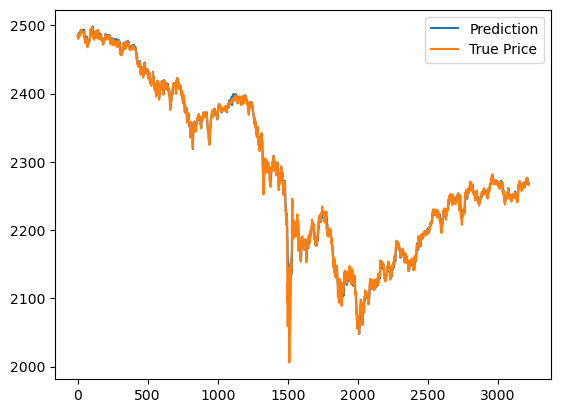

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100, 20,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 100, 10,   │         96 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 100, 10,   │      4,128 │ conv2d_60[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 100, 5,    │      2,080 │ conv2d_61[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 100, 5,    │      4,128 │ conv2d_62[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 10, 5, 32) │     10,272 │ conv2d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 10, 5, 64) │      2,112 │ conv2d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 10, 5, 64) │      2,112 │ conv2d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 10, 5, 32) │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 10, 5, 64) │     12,352 │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 10, 5, 64) │     20,544 │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 10, 5, 64) │      2,112 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 10, 5,     │          0 │ conv2d_66[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_68[0][0],  │
│                     │                   │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 50, 192)   │          0 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     65,792 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - loss: 0.1206 - mae: 0.1846 - val_loss: 0.0073 - val_mae: 0.0547
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 162ms/step - loss: 0.0021 - mae: 0.0343 - val_loss: 0.0053 - val_mae: 0.0443
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0043 - val_mae: 0.0420
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - loss: 8.6522e-04 - mae: 0.0217 - val_loss: 0.0038 - val_mae: 0.0418
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step - loss: 8.9707e-04 - mae: 0.0217 - val_loss: 0.0024 - val_mae: 0.0284
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 168ms/step - loss: 9.8976e-04 - mae: 0.0228 - val_loss: 0.0022 - val_mae: 0.0284
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - loss: 5.5256e-04 - mae: 0.0172 - val_loss: 0.0021 - val_mae: 0.0281
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 177ms/step - loss: 6.7218e-04 - mae: 0.0189 - val_loss: 0.0020 - val_mae: 0.0285
Epoch 9/15
2

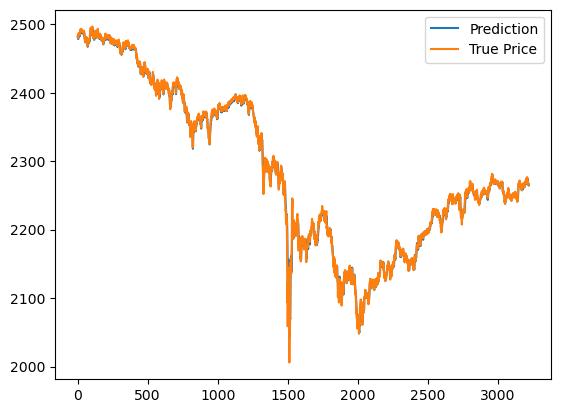

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 100, 20,   │         96 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 100, 20,   │      4,128 │ conv2d_70[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 100, 10,   │      2,080 │ conv2d_71[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 100, 10,   │      4,128 │ conv2d_72[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 10, 10,    │     10,272 │ conv2d_73[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 10, 10,    │      2,112 │ conv2d_74[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 10, 10,    │      2,112 │ conv2d_74[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 10, 10,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 10, 10,    │     12,352 │ conv2d_75[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 10, 10,    │     20,544 │ conv2d_77[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 10, 10,    │      2,112 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 10, 10,    │          0 │ conv2d_76[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_78[0][0],  │
│                     │                   │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 100, 192)  │          0 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 64)        │     65,792 │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 79s 338ms/step - loss: 0.1463 - mae: 0.1942 - val_loss: 0.0050 - val_mae: 0.0433
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 78s 366ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 0.0034 - val_mae: 0.0322
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 86s 405ms/step - loss: 8.3015e-04 - mae: 0.0216 - val_loss: 0.0039 - val_mae: 0.0430
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 73s 344ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0025 - val_mae: 0.0276
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 61s 285ms/step - loss: 6.2852e-04 - mae: 0.0188 - val_loss: 0.0022 - val_mae: 0.0264
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 267ms/step - loss: 5.3809e-04 - mae: 0.0173 - val_loss: 0.0021 - val_mae: 0.0262
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - loss: 6.6596e-04 - mae: 0.0194 - val_loss: 0.0019 - val_mae: 0.0239
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 271ms/step - loss: 4.3886e-04 - mae: 0.0156 - val_loss: 0.0028 - val_mae: 0.0380
Epoch 9/15
2

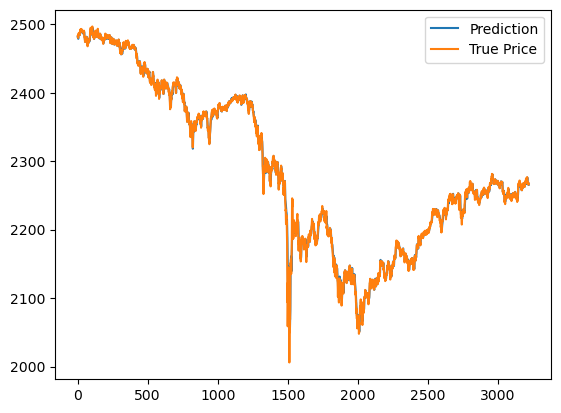

In [40]:


window_size = 100
num_levels = [3, 5, 10]

for lvl in num_levels:
    dp = DataPreprocess()
    
    df = dp.load_data("archive/ETH_1min.csv")
    
    df = dp.get_bid_levels(df, lvl)
    
    data_length = df.shape[0]
    train_length = round(0.8 * data_length)
    
    windows_train, windows_test = dp.r_get_window(df, train_length, window_size)
    
    nm_lvl = len(df.columns) - 2
    
    model2 = get_model(nm_lvl, window_size)
    
    # Compile the model
    model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    
    # Model Summary
    model2.summary()
    
    history = model2.fit(
        windows_train,
        validation_data=windows_test,
        epochs=15,
        batch_size=64,
        verbose=1
    )

    calculate_metrics_and_plot(model2, train_length, lvl)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 15,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 100, 8,    │         96 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 100, 8,    │      4,128 │ conv2d_80[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 100, 4,    │      2,080 │ conv2d_81[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 100, 4,    │      4,128 │ conv2d_82[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 10, 4, 32) │     10,272 │ conv2d_83[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 10, 4, 64) │      2,112 │ conv2d_84[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 10, 4, 64) │      2,112 │ conv2d_84[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 10, 4, 32) │          0 │ conv2d_84[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 10, 4, 64) │     12,352 │ conv2d_85[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 10, 4, 64) │     20,544 │ conv2d_87[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 10, 4, 64) │      2,112 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 10, 4,     │          0 │ conv2d_86[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_88[0][0],  │
│                     │                   │            │ conv2d_89[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 40, 192)   │          0 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 64)        │     65,792 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ lstm_8[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - loss: 0.1710 - mae: 0.2233 - val_loss: 0.0074 - val_mae: 0.0537
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0063 - val_mae: 0.0503
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 0.0054 - val_mae: 0.0447
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - loss: 0.0013 - mae: 0.0267 - val_loss: 0.0047 - val_mae: 0.0427
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - loss: 9.5646e-04 - mae: 0.0233 - val_loss: 0.0039 - val_mae: 0.0368
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step - loss: 0.0011 - mae: 0.0253 - val_loss: 0.0038 - val_mae: 0.0383
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - loss: 7.7585e-04 - mae: 0.0209 - val_loss: 0.0033 - val_mae: 0.0322
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - loss: 8.4519e-04 - mae: 0.0220 - val_loss: 0.0035 - val_mae: 0.0355
Epoch 9/15
213/213 ━

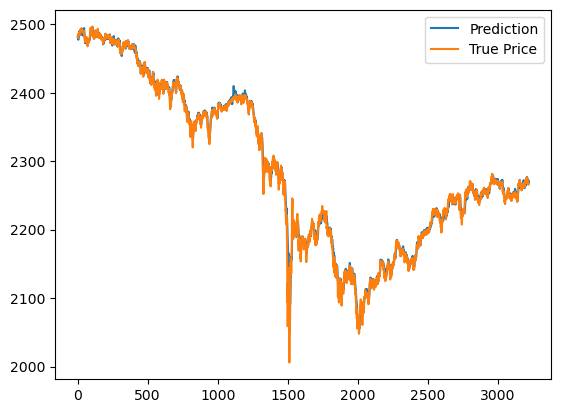

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 100, 25,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 100, 13,   │         96 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 100, 13,   │      4,128 │ conv2d_90[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 100, 7,    │      2,080 │ conv2d_91[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 100, 7,    │      4,128 │ conv2d_92[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 10, 7, 32) │     10,272 │ conv2d_93[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 10, 7, 64) │      2,112 │ conv2d_94[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 10, 7, 64) │      2,112 │ conv2d_94[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 10, 7, 32) │          0 │ conv2d_94[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 10, 7, 64) │     12,352 │ conv2d_95[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 10, 7, 64) │     20,544 │ conv2d_97[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 10, 7, 64) │      2,112 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 10, 7,     │          0 │ conv2d_96[0][0],  │
│ (Concatenate)       │ 192)              │            │ conv2d_98[0][0],  │
│                     │                   │            │ conv2d_99[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 70, 192)   │          0 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 64)        │     65,792 │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ lstm_9[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - loss: 0.1643 - mae: 0.2285 - val_loss: 0.0065 - val_mae: 0.0515
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 0.0058 - val_mae: 0.0506
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 0.0046 - val_mae: 0.0419
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0050 - val_mae: 0.0483
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 199ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0035 - val_mae: 0.0336
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - loss: 7.8470e-04 - mae: 0.0207 - val_loss: 0.0035 - val_mae: 0.0360
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - loss: 7.2515e-04 - mae: 0.0197 - val_loss: 0.0032 - val_mae: 0.0339
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - loss: 6.5909e-04 - mae: 0.0189 - val_loss: 0.0029 - val_mae: 0.0316
Epoch 9/15
213/213 ━

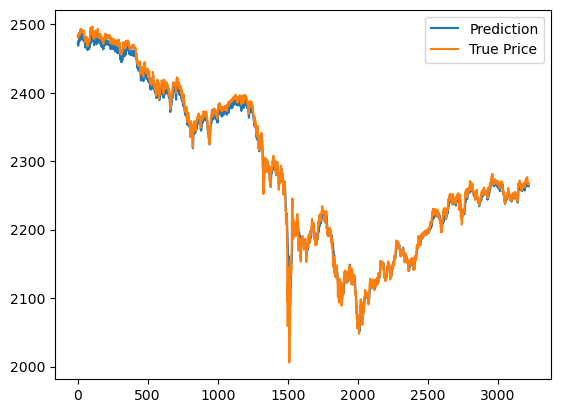

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100, 50,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 100, 25,   │         96 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 100, 25,   │      4,128 │ conv2d_100[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 100, 13,   │      2,080 │ conv2d_101[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 100, 13,   │      4,128 │ conv2d_102[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 10, 13,    │     10,272 │ conv2d_103[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 10, 13,    │      2,112 │ conv2d_104[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 10, 13,    │      2,112 │ conv2d_104[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 10, 13,    │          0 │ conv2d_104[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 10, 13,    │     12,352 │ conv2d_105[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 10, 13,    │     20,544 │ conv2d_107[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 10, 13,    │      2,112 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 10, 13,    │          0 │ conv2d_106[0][0], │
│ (Concatenate)       │ 192)              │            │ conv2d_108[0][0], │
│                     │                   │            │ conv2d_109[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 130, 192)  │          0 │ concatenate_10[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 64)        │     65,792 │ reshape_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         65 │ lstm_10[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,793 (491.38 KB)

 Trainable params: 125,793 (491.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 80s 348ms/step - loss: 0.1308 - mae: 0.1956 - val_loss: 0.0057 - val_mae: 0.0475
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 71s 334ms/step - loss: 0.0014 - mae: 0.0279 - val_loss: 0.0042 - val_mae: 0.0374
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 67s 313ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0039 - val_mae: 0.0380
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 68s 318ms/step - loss: 8.0810e-04 - mae: 0.0212 - val_loss: 0.0033 - val_mae: 0.0331
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 70s 328ms/step - loss: 6.4899e-04 - mae: 0.0191 - val_loss: 0.0030 - val_mae: 0.0311
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step - loss: 7.6926e-04 - mae: 0.0208 - val_loss: 0.0029 - val_mae: 0.0336
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 80s 375ms/step - loss: 6.9265e-04 - mae: 0.0199 - val_loss: 0.0026 - val_mae: 0.0303
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 85s 401ms/step - loss: 7.3683e-04 - mae: 0.0200 - val_loss: 0.0024 - val_mae: 0.0273
Epoch 9/15
2

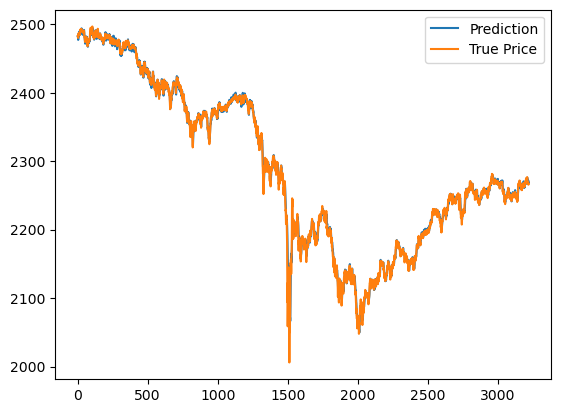

In [44]:
window_size = 100
num_levels = [3, 5, 10]

is_ofi = True

for lvl in num_levels:
    dp = DataPreprocess()
    
    df = dp.load_data("archive/ETH_1min.csv")
    
    df = dp.get_bid_levels(df, lvl)

    if is_ofi:
        df = dp.get_bid_with_ofi_levels(df, lvl)
        
    data_length = df.shape[0]
    train_length = round(0.8 * data_length)
    
    windows_train, windows_test = dp.r_get_window(df, train_length, window_size)
    
    nm_lvl = len(df.columns) - 2
    
    model2 = get_model(nm_lvl, window_size)
    
    # Compile the model
    model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    
    # Model Summary
    model2.summary()
    
    history = model2.fit(
        windows_train,
        validation_data=windows_test,
        epochs=15,
        batch_size=64,
        verbose=1
    )

    calculate_metrics_and_plot(model2, train_length, lvl)